In [1]:
# # example of preparing the horses and zebra dataset
# from os import listdir
# from numpy import asarray
# from numpy import vstack
# from keras.preprocessing.image import img_to_array
# from keras.preprocessing.image import load_img
# from numpy import savez_compressed

# # load all images in a directory into memory
# def load_images(path, size=(256,256)):
# 	data_list = list()
# 	# enumerate filenames in directory, assume all are images
# 	for filename in listdir(path):
# 		# load and resize the image
# 		pixels = load_img(path + filename, target_size=size)
# 		# convert to numpy array
# 		pixels = img_to_array(pixels)
# 		# store
# 		data_list.append(pixels)
# 	return asarray(data_list)



In [2]:
# # dataset path
# path = '../input/abdata-v1/'
# # load dataset A
# dataA1 = load_images(path + 'trainA/')
# dataAB = load_images(path + 'testA/')
# dataA = vstack((dataA1, dataAB))
# print('Loaded dataA: ', dataA.shape)
# # load dataset B
# dataB1 = load_images(path + 'trainB/')
# dataB2 = load_images(path + 'testB/')
# dataB = vstack((dataB1, dataB2))
# print('Loaded dataB: ', dataB.shape)
# # save as compressed numpy array
# filename = 'holo2optic_256.npz'
# savez_compressed(filename, dataA, dataB)
# print('Saved dataset: ', filename)

Loaded:  (1050, 256, 256, 3) (1050, 256, 256, 3)


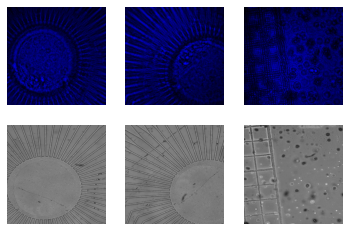

In [3]:
# load and plot the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load('../input/abdata-v1/holo2optic_256.npz')
dataA, dataB = data['arr_0'], data['arr_1']
print('Loaded: ', dataA.shape, dataB.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(dataB[i].astype('uint8'))
pyplot.show()

In [4]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-pz62yxk0
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-pz62yxk0
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101064 sha256=ab0164b4cb86dbfd4cb52b3e265cc5a63edc69fe10e30907ee1e73760bc2fd19
  Stored in directory: /tmp/pip-ephem-wheel-cache-u9axkzv6/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


In [5]:
# example of training a cyclegan on the horse2zebra dataset
# example of preparing the horses and zebra dataset
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot
import numpy as np
import tensorflow as tf
from tensorflow import keras

The define_discriminator() function below implements the 70×70 PatchGAN discriminator model as per the design of the model in the paper. The model takes a 256×256 sized image as input and outputs a patch of predictions. The model is optimized using least squares loss (L2) implemented as mean squared error, and a weighting it used so that updates to the model have half (0.5) the usual effect. The authors of CycleGAN paper recommend this weighting of model updates to slow down changes to the discriminator, relative to the generator model during training.

In [6]:
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

The generator model is more complex than the discriminator model.

The generator is an encoder-decoder model architecture. The model takes a source image (e.g. horse photo) and generates a target image (e.g. zebra photo). It does this by first downsampling or encoding the input image down to a bottleneck layer, then interpreting the encoding with a number of ResNet layers that use skip connections, followed by a series of layers that upsample or decode the representation to the size of the output image.

First, we need a function to define the ResNet blocks. These are blocks comprised of two 3×3 CNN layers where the input to the block is concatenated to the output of the block, channel-wise.

This is implemented in the resnet_block() function that creates two Convolution-InstanceNorm blocks with 3×3 filters and 1×1 stride and without a ReLU activation after the second block, matching the official Torch implementation in the build_conv_block() function. Same padding is used instead of reflection padded recommended in the paper for simplicity.

In [7]:
# generator a resnet block
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g


Next, we can define a function that will create the 9-resnet block version for 256×256 input images. This can easily be changed to the 6-resnet block version by setting image_shape to (128x128x3) and n_resnet function argument to 6.

Importantly, the model outputs pixel values with the shape as the input and pixel values are in the range [-1, 1], typical for GAN generator models.

In [8]:
# define the standalone generator model
def define_generator(image_shape, n_resnet=9):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

To summarize, a composite model has two inputs for the real photos from Domain-A and Domain-B, and four outputs for the discriminator output, identity generated image, forward cycle generated image, and backward cycle generated image.

Only the weights of the first or main generator model are updated for the composite model and this is done via the weighted sum of all loss functions. The cycle loss is given more weight (10-times) than the adversarial loss as described in the paper, and the identity loss is always used with a weighting half that of the cycle loss (5-times), matching the official implementation source code.

In [9]:
# define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False
	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

Next, we can load our paired images dataset in compressed NumPy array format. This will return a list of two NumPy arrays: the first for source images and the second for corresponding target images.

In [10]:

# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]


The generate_real_samples() function below implements this, taking a NumPy array for a domain as input and returning the requested number of randomly selected images, as well as the target for the PatchGAN discriminator model indicating the images are real (target=1.0). As such, the shape of the PatchgAN output is also provided, which in the case of 256×256 images will be 16, or a 16x16x1 activation map, defined by the patch_shape function argument.

The generate_fake_samples() function below generates this sample given a generator model and the sample of real images from the source domain. Again, target values for each generated image are provided with the correct shape of the PatchGAN, indicating that they are fake or generated (target=0.0).

In [11]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

The save_models() function below will save each generator model to the current directory in H5 format, including the training iteration number in the filename. This will require that the h5py library is installed.

In [12]:
# save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
	# save the first generator model
	filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

The summarize_performance() function below uses a given generator model to generate translated versions of a few randomly selected source photographs and saves the plot to file.

The source images are plotted on the first row and the generated images are plotted on the second row. Again, the plot filename includes the training iteration number.

In [13]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	# save plot to file
	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()

The paper defines an image pool of 50 generated images for each discriminator model that is first populated and probabilistically either adds new images to the pool by replacing an existing image or uses a generated image directly. We can implement this as a Python list of images for each discriminator and use the update_image_pool() function below to maintain each pool list.

In [14]:
# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

The train() function below takes all six models (two discriminator, two generator, and two composite models) as arguments along with the dataset and trains the models.

The batch size is fixed at one image to match the description in the paper and the models are fit for 100 epochs. Given that the horses dataset has 1,187 images, one epoch is defined as 1,187 batches and the same number of training iterations. Images are generated using both generators each epoch and models are saved every five epochs or (1187 * 5) 5,935 training iterations.

The order of model updates is implemented to match the official Torch implementation. First, a batch of real images from each domain is selected, then a batch of fake images for each domain is generated. The fake images are then used to update each discriminator’s fake image pool.

Next, the Generator-A model (zebras to horses) is updated via the composite model, followed by the Discriminator-A model (horses). Then the Generator-B (horses to zebra) composite model and Discriminator-B (zebras) models are updated.

Loss for each of the updated models is then reported at the end of the training iteration. Importantly, only the weighted average loss used to update each generator is reported.

In [15]:
# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
	# define properties of the training run
	n_epochs, n_batch, = 5, 4
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fakes
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fakes from pool
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
		# update generator B->A via adversarial and cycle loss
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		# update generator A->B via adversarial and cycle loss
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		# summarize performance
		print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance every so often
		if (i+1) % (bat_per_epo * 1) == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if (i+1) % (bat_per_epo * 5) == 0:
			# save the models
			save_models(i, g_model_AtoB, g_model_BtoA)

In [16]:


# load image data
dataset = load_real_samples('../input/abdata-v1/holo2optic_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]


Loaded (1050, 256, 256, 3) (1050, 256, 256, 3)


In [17]:
type(dataset[0])

numpy.ndarray

In [18]:
image_shape

(256, 256, 3)

In [19]:
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)


In [20]:
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

>1, dA[0.739,1.343] dB[2.807,0.832] g[23.008,20.705]
>2, dA[4.863,1.078] dB[7.437,1.348] g[19.129,20.187]
>3, dA[1.961,1.047] dB[3.819,2.287] g[19.730,19.663]
>4, dA[2.526,2.093] dB[3.459,1.911] g[17.449,19.558]
>5, dA[2.417,5.978] dB[2.051,4.638] g[17.283,22.629]
>6, dA[2.502,3.388] dB[0.996,4.451] g[17.373,21.435]
>7, dA[4.788,2.551] dB[0.745,2.605] g[16.481,20.048]
>8, dA[6.394,1.754] dB[0.829,4.678] g[18.702,21.171]
>9, dA[9.345,2.251] dB[0.598,1.660] g[13.508,19.948]
>10, dA[2.289,1.322] dB[0.582,0.708] g[12.223,15.958]
>11, dA[0.540,0.488] dB[0.418,1.039] g[11.886,15.269]
>12, dA[0.413,0.316] dB[0.458,0.784] g[11.071,14.409]
>13, dA[0.261,0.283] dB[0.428,0.434] g[11.466,14.950]
>14, dA[0.254,0.317] dB[0.443,0.394] g[11.460,14.702]
>15, dA[0.181,0.267] dB[0.386,0.424] g[10.208,13.628]
>16, dA[0.240,0.271] dB[0.360,0.365] g[11.031,14.394]
>17, dA[0.177,0.229] dB[0.365,0.290] g[10.070,13.510]
>18, dA[0.177,0.207] dB[0.323,0.269] g[10.781,14.015]
>19, dA[0.186,0.253] dB[0.351,0.236] 

In [21]:
# # load dataset
# A_data, B_data = load_real_samples('../input/horse2zebra/horse2zebra_256.npz')
# print('Loaded', A_data.shape, B_data.shape)

In [22]:
# # load the models
# cust = {'InstanceNormalization': InstanceNormalization}
# model_AtoB =  keras.models.load_model('../input/horse2zebra/results/g_model_AtoB_001480.h5', cust)
# model_BtoA =  keras.models.load_model('../input/horse2zebra/results/g_model_BtoA_001480.h5', cust)

In [23]:
# # select a random sample of images from the dataset
# def select_sample(dataset, n_samples):
# 	# choose random instances
# 	ix = randint(0, dataset.shape[0], n_samples)
# 	# retrieve selected images
# 	X = dataset[ix]
# 	return X

In [24]:
# # plot A->B->A
# A_real = select_sample(A_data, 1)
# B_generated  = model_AtoB.predict(A_real)
# A_reconstructed = model_BtoA.predict(B_generated)

In [25]:
# # plot the image, the translation, and the reconstruction
# def show_plot(imagesX, imagesY1, imagesY2):
# 	images = vstack((imagesX, imagesY1, imagesY2))
# 	titles = ['Real', 'Generated', 'Reconstructed']
# 	# scale from [-1,1] to [0,1]
# 	images = (images + 1) / 2.0
# 	# plot images row by row
# 	for i in range(len(images)):
# 		# define subplot
# 		pyplot.subplot(1, len(images), 1 + i)
# 		# turn off axis
# 		pyplot.axis('off')
# 		# plot raw pixel data
# 		pyplot.imshow(images[i])
# 		# title
# 		pyplot.title(titles[i])
# 	pyplot.show()

In [26]:
# show_plot(A_real, B_generated, A_reconstructed)

In [27]:
# # plot B->A->B
# B_real = select_sample(B_data, 1)
# A_generated  = model_BtoA.predict(B_real)
# B_reconstructed = model_AtoB.predict(A_generated)
# show_plot(B_real, A_generated, B_reconstructed)